In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import jax
from jax import random
from jax import numpy as jnp

from flax.training import train_state
import optax

from npf.jax.models import CNP, NP, AttnCNP, AttnNP, BNP, BANP, ConvCNP, ConvNP
from npf.jax.data import GPSampler, RBFKernel

from tqdm.auto import trange

In [3]:
def get_train_step(**kwargs):
    @jax.jit
    def train_step(state, rngs, x_ctx, y_ctx, x_tar, y_tar, mask_ctx, mask_tar):
        def loss_fn(params):
            loss = model.apply(
                params,
                x_ctx=x_ctx,
                y_ctx=y_ctx,
                x_tar=x_tar,
                y_tar=y_tar,
                mask_ctx=mask_ctx,
                mask_tar=mask_tar,
                rngs=rngs,
                method=model.loss,
                **kwargs,
            )
            return loss

        grad_fn = jax.value_and_grad(loss_fn)
        loss, grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss
    return train_step

In [4]:
def get_eval_step(**kwargs):
    @jax.jit
    def eval_step(state, rngs, x_ctx, y_ctx, x_tar, y_tar, mask_ctx, mask_tar):
        loss = model.apply(
            state.params,
            x_ctx=x_ctx,
            y_ctx=y_ctx,
            x_tar=x_tar,
            y_tar=y_tar,
            mask_ctx=mask_ctx,
            mask_tar=mask_tar,
            rngs=rngs,
            method=model.loss,
            **kwargs,
        )
        return loss
    return eval_step

In [5]:
x_ctx    = jnp.ones((1, 3, 1))
y_ctx    = jnp.ones((1, 3, 1))
x_tar    = jnp.ones((1, 4, 1))
y_tar    = jnp.ones((1, 4, 1))
mask_ctx = jnp.ones(3)
mask_tar = jnp.ones(4)

# model = CNP(y_dim=1)
model = ConvNP(y_dim=1, x_min=-2, x_max=2)
sampler = GPSampler(RBFKernel())

key = random.PRNGKey(0)
key, params_init_key, sample_init_key = random.split(key, 3)

params = model.init(dict(
    params=params_init_key,
    sample=sample_init_key,
), x_ctx, y_ctx, x_tar, mask_ctx, mask_tar)

tx = optax.adam(learning_rate=5e-4)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [6]:
kwargs = dict(
    # loss_type="ml",
    num_latents=10,
    # num_samples=5,
)

num_steps = 10000

train_step = get_train_step(**kwargs)
eval_step  = get_eval_step(**kwargs)

for i in trange(1, num_steps + 1):
    key, model_key, data_key = random.split(key, 3)
    batch = sampler.sample(data_key, batch_size=256)
    state, loss = train_step(
        state,
        dict(sample=model_key),
        x_ctx=batch.x_ctx,
        y_ctx=batch.y_ctx,
        x_tar=batch.x,
        y_tar=batch.y,
        mask_ctx=batch.mask_ctx,
        mask_tar=batch.mask,
    )

    if i % 100 == 0:
        loss_ctx = eval_step(
            state,
            dict(sample=model_key),
            x_ctx=batch.x_ctx,
            y_ctx=batch.y_ctx,
            x_tar=batch.x_ctx,
            y_tar=batch.y_ctx,
            mask_ctx=batch.mask_ctx,
            mask_tar=batch.mask_ctx,
        )
        loss_tar = eval_step(
            state,
            dict(sample=model_key),
            x_ctx=batch.x_ctx,
            y_ctx=batch.y_ctx,
            x_tar=batch.x_tar,
            y_tar=batch.y_tar,
            mask_ctx=batch.mask_ctx,
            mask_tar=batch.mask_tar,
        )

        print(f"Step {i}/{num_steps}  CTX Loss: {loss_ctx:7.4f}  TAR Loss: {loss_tar:7.4f}  Loss: {loss:7.4f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 100/10000  CTX Loss:  0.3987  TAR Loss:  0.4456  Loss:  0.4274
Step 200/10000  CTX Loss: -0.2346  TAR Loss: -0.0668  Loss: -0.1756
Step 300/10000  CTX Loss: -0.4252  TAR Loss:  0.1279  Loss: -0.0947
Step 400/10000  CTX Loss: -0.8112  TAR Loss: -0.5299  Loss: -0.7339
Step 500/10000  CTX Loss: -0.8292  TAR Loss: -0.3412  Loss: -0.8206
Step 600/10000  CTX Loss:  0.1480  TAR Loss:  0.3610  Loss:  0.2777
Step 700/10000  CTX Loss: -1.0865  TAR Loss: -0.3772  Loss: -0.9047
Step 800/10000  CTX Loss: -1.0809  TAR Loss:  0.2717  Loss:  0.0269
Step 900/10000  CTX Loss: -0.2743  TAR Loss: -0.3435  Loss: -0.6923
Step 1000/10000  CTX Loss:  1.7897  TAR Loss:  1.0169  Loss: -0.7585
Step 1100/10000  CTX Loss: -1.0347  TAR Loss: -0.7147  Loss: -0.9305
Step 1200/10000  CTX Loss: -1.4573  TAR Loss: -0.2038  Loss: -0.7701
Step 1300/10000  CTX Loss: -1.4569  TAR Loss: -0.7958  Loss: -1.2099
Step 1400/10000  CTX Loss: -1.4102  TAR Loss: -0.6819  Loss: -1.1124
Step 1500/10000  CTX Loss: -1.4981  TAR Los

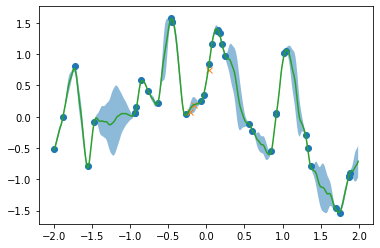

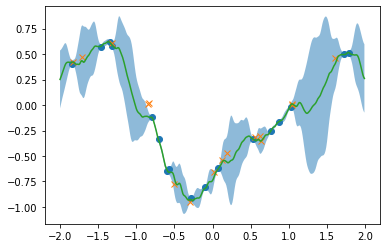

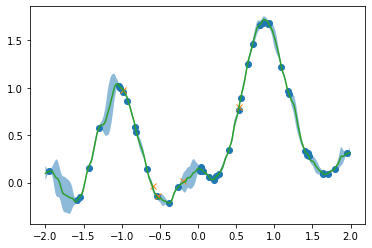

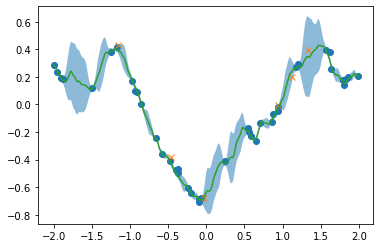

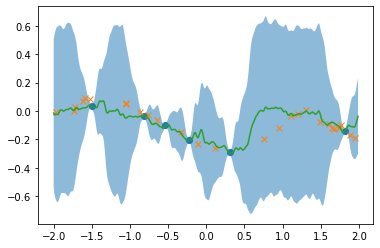

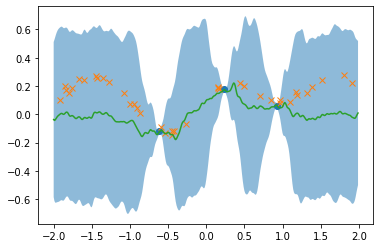

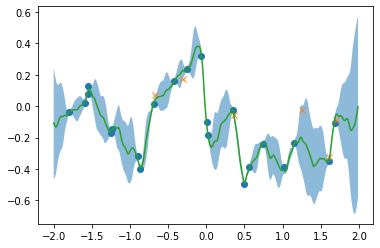

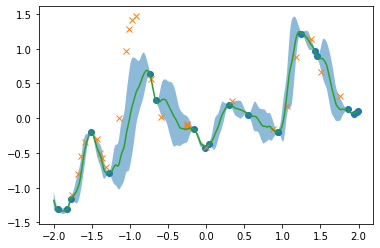

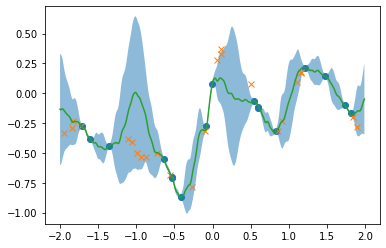

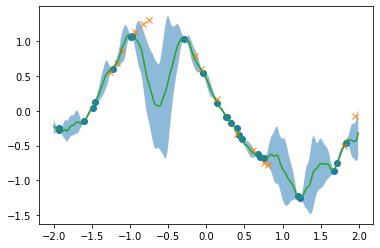

In [7]:
import matplotlib.pyplot as plt

for i in range(10):
    model_key, data_key = random.split(random.PRNGKey(i+10), 2)
    batch = sampler.sample(data_key, batch_size=5)
    
    x = jnp.arange(-2, 2, 0.01).reshape((1, -1, 1)).repeat(batch.x.shape[0], axis=0)
    batch.x = x
    batch.mask = jnp.ones(batch.x.shape[1], dtype=jnp.bool_)
    
    mu, sigma = model.apply(state.params, batch.x_ctx, batch.y_ctx, batch.x, batch.mask_ctx, batch.mask, rngs=dict(sample=model_key))
    if mu.shape[1] == 1:
        mu, sigma = mu.squeeze(axis=1), sigma.squeeze(axis=1)

    idx     = [d for d in jnp.argsort(batch.x[0, :, 0])     if batch.mask[d] > 0]
    idx_ctx = [d for d in jnp.argsort(batch.x_ctx[0, :, 0]) if batch.mask_ctx[d] > 0]
    idx_tar = [d for d in jnp.argsort(batch.x_tar[0, :, 0]) if batch.mask_tar[d] > 0]

    plt.figure()
    plt.plot(batch.x_ctx[0, idx_ctx, 0], batch.y_ctx[0, idx_ctx, 0], 'o')
    plt.plot(batch.x_tar[0, idx_tar, 0], batch.y_tar[0, idx_tar, 0], 'x')
    plt.plot(batch.x[0, idx, 0], mu[0, idx, 0], '-')
    plt.fill_between(batch.x[0, idx, 0], mu[0, idx, 0] - sigma[0, idx, 0], mu[0, idx, 0] + sigma[0, idx, 0], alpha=0.5)
    plt.plot()